<a href="https://colab.research.google.com/github/arushi-lu/deep_learning/blob/main/BP_Estimation_upd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import random
import h5py
random.seed(0) # for validation


Utility functions (main):
1. to_timeseries: convert EEG+PPG and ABP to time-series
2. zero_order_holding_first: apply zero_order to systolic and dyastolic peaks (eliminate the varying pressure between systolic and diastolic pressure)
3. zero_order_second: noise reduction

In [2]:
import numpy as np


def convert_to_2d(arr, index=None):
    array = []
    if index != None:
        for subject_index in range(arr.shape[0]):
            array.extend(arr[subject_index][index])
    else:
        for subject_index in range(arr.shape[0]):
            array.extend(arr[subject_index])
    return np.array(array)

def find_max_min(arr):
    arr_min = np.min(arr)
    arr_max = np.max(arr)

    return arr_min, arr_max

def to_timeseries(X, y, is_train, max_len):
    """
    generate data for one user.
    """
    seq_x = []
    seqs_x = []
    seqs_y = []
    seq_y = []

    min_max = np.load(data_path+'min_max.npy')
    min_max_train = np.load(data_path+'min_max_train.npy')

    ppg_all_min, ppg_all_max = min_max[0]
    ecg_all_min, ecg_all_max = min_max[1]
    abp_all_min, abp_all_max = min_max[2]

    ppg_train_min, ppg_train_max = min_max_train[0]
    ecg_train_min, ecg_train_max = min_max_train[1]
    abp_train_min, abp_train_max = min_max_train[2]

    for i in range(X[0].shape[0]):
        if len(seq_x) < max_len:
            if is_train:
                seq_x.append([
                    (X[0][i]-ppg_train_min)/(ppg_train_max-ppg_train_min),
                    (X[1][i]-ecg_train_min)/(ecg_train_max-ecg_train_min)
                ])
                seq_y.append([(y[i]-abp_train_min)/(abp_train_max-abp_train_min)])
            else:
                seq_x.append([
                    (X[0][i]-ppg_all_min)/(ppg_all_max-ppg_all_min),
                    (X[1][i]-ecg_all_min)/(ecg_all_max-ecg_all_min)
                ])
                seq_y.append([(y[i]-abp_all_min)/(abp_all_max-abp_all_min)])
        else:
            seq_x = seq_x[1:]
            seq_y = seq_y[1:]
            if is_train:
                seq_x.append([
                    (X[0][i]-ppg_train_min)/(ppg_train_max-ppg_train_min),
                    (X[1][i]-ecg_train_min)/(ecg_train_max-ecg_train_min)
                ])
                seq_y.append([(y[i]-abp_train_min)/(abp_train_max-abp_train_min)])
            else:
                seq_x.append([(X[0][i]-ppg_all_min)/(ppg_all_max-ppg_all_min), (X[1][i]-ecg_all_min)/(ecg_all_max-ecg_all_min)])
                seq_y.append([(y[i]-abp_all_min)/(abp_all_max-abp_all_min)])
        if len(seq_x) < max_len:
            continue
        else:
            seqs_x.append(seq_x)
            seqs_y.append(seq_y)

    zeros_y = np.zeros((len(seqs_y), max_len, 1))
    return seqs_x, zeros_y, seqs_y

def find_abp_peak_sys(abp, delay):
    index_max_abp = []
    loop_count = int(len(abp)/delay)
    index = 0
    for i in range(loop_count):
        max_value = 0
        max_index = 0
        for j in abp[i*delay:(i+1)*delay]:
            if j > max_value:
                max_value = j
                max_index = index

            index = index + 1
        index_max_abp.append(max_index)

    return index_max_abp

def find_abp_peak_dia(abp, delay):
    index_min_abp = []
    loop_count = int(len(abp)/delay)
    index = 0
    for i in range(loop_count):
        min_value = 9999999999
        min_index = 0
        for j in abp[i*delay:(i+1)*delay]:
            if j < min_value:
                min_value = j
                min_index = index
            index = index + 1

        index_min_abp.append(min_index)

    return index_min_abp

def zero_order_holding_first(abp, delay, is_sys):
    if is_sys:
        index_max_abp = find_abp_peak_sys(abp, delay)
    else:
        index_max_abp = find_abp_peak_dia(abp, delay)

    peak_abp = np.zeros(len(abp))
    j = 0
    for i in range(len(abp)):
        if i < index_max_abp[j]:
            if j == 1:
                peak_abp[i] = abp[index_max_abp[0]]
            else:
                peak_abp[i] = abp[index_max_abp[j-1]]
        else:
            j = j + 1
            if j >= len(index_max_abp):
                j = j - 1
            if j == 1:
                peak_abp[i] = abp[index_max_abp[0]]
            else:
                peak_abp[i] = abp[index_max_abp[j-1]]

    return peak_abp

def zero_order_second(signal):
    change = 0
    num = len(signal)
    for i in range(0, num-10):
        counter = 0
        if signal[i+1] != signal[i]:
            change = 1
            for j in range(1, 12):
                if signal[i+j] == signal[i]:
                    counter = counter + 1
        if change == 1 and counter > 0:
            for j in range(0, 11):
                signal[i+j] = signal[i]
        change = 0
    return signal

Data loading
Original data was dowloaded from:
https://www.kaggle.com/datasets/mkachuee/BloodPressureDataset?select=part_1.mat

The data from original repository has issues:
https://archive.ics.uci.edu/dataset/340/cuff+less+blood+pressure+estimation

https://drive.google.com/file/d/11w0fhkEe7MJq7JRoXmoJV8IHJQeGzdiC/view?usp=sharing


In [3]:
#!pip install gdown

# To Download the file from Google Drive
import gdown

In [4]:
file_id = "11w0fhkEe7MJq7JRoXmoJV8IHJQeGzdiC"
download_url = f"https://drive.google.com/uc?id={file_id}"
output_file = "part_1.mat"

gdown.download(download_url, output_file, quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=11w0fhkEe7MJq7JRoXmoJV8IHJQeGzdiC
From (redirected): https://drive.google.com/uc?id=11w0fhkEe7MJq7JRoXmoJV8IHJQeGzdiC&confirm=t&uuid=9155ec5e-b0c4-4e1a-ac6b-acbbfefb9cab
To: /content/part_1.mat
100%|██████████| 472M/472M [00:09<00:00, 50.9MB/s]


'part_1.mat'

In [5]:
data_path = '/content/part_1.mat'

In [6]:
M = scipy.io.loadmat(data_path)['p'][0]

Authors used 84 subjects for training

In [7]:
M = M[:84]
M.shape

(84,)

In [8]:
ex_ppg = M[0][0][0:400]
ex_ecg = M[0][2][0:400]
ex_abp = M[0][1][0:400]

Visualization of PPG signal


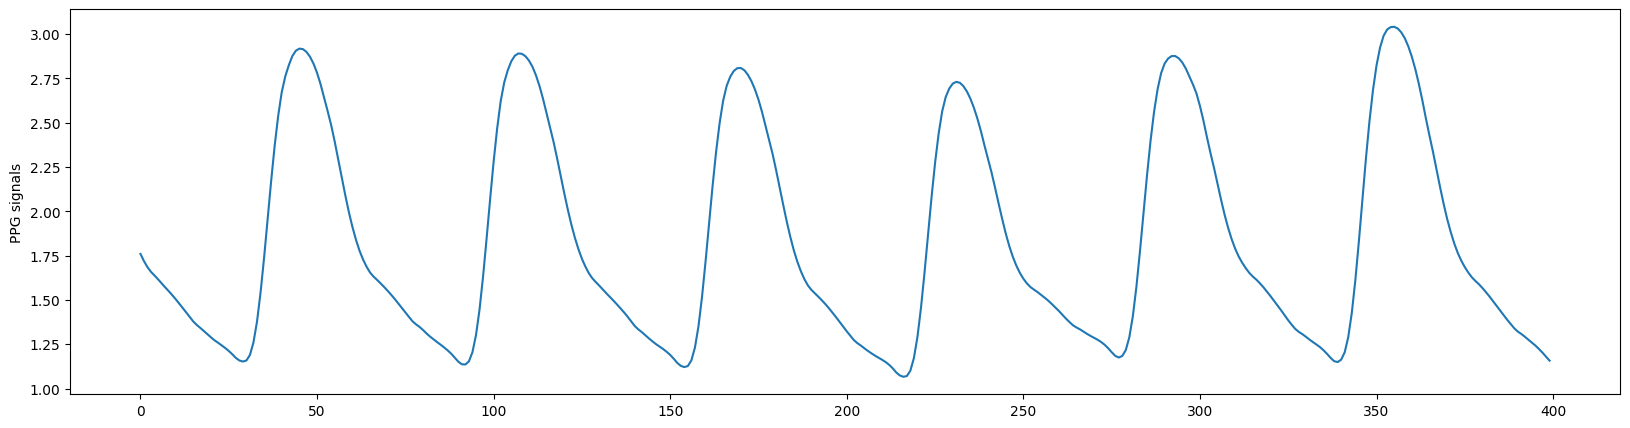

In [9]:
plt.figure(figsize=(20,5))
plt.plot(ex_ppg)
plt.ylabel('PPG signals')
plt.show()


Visualization of ECG signal

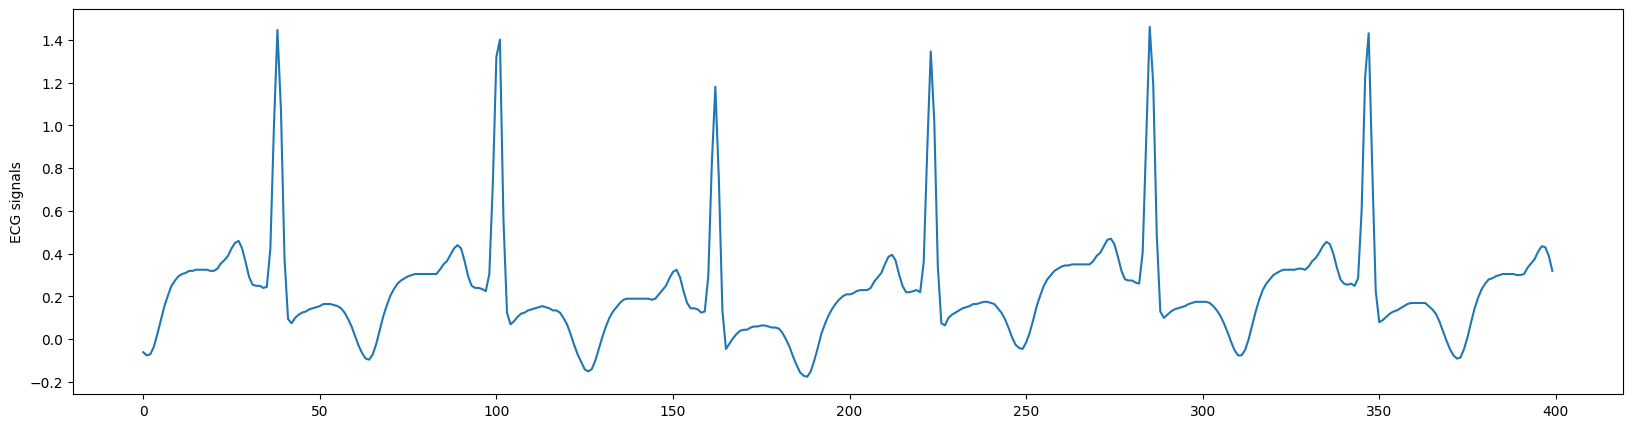

In [10]:
plt.figure(figsize=(20,5))
plt.plot(ex_ecg)
plt.ylabel('ECG signals')
plt.show()

Visualization of ABP signal

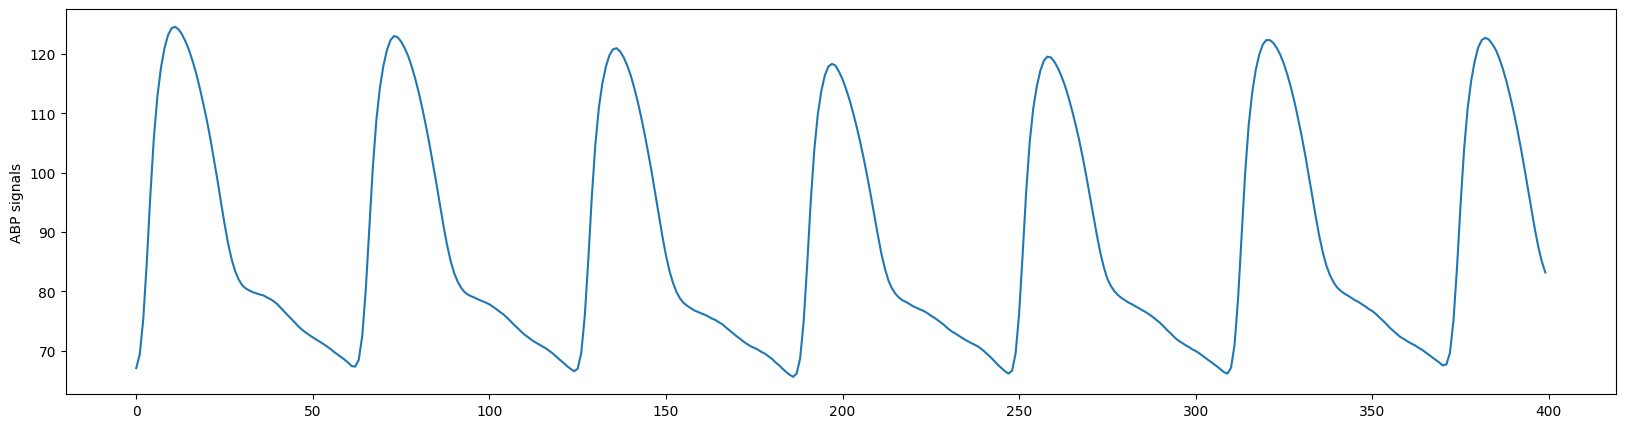

In [11]:
plt.figure(figsize=(20,5))
plt.plot(ex_abp)
plt.ylabel('ABP signals')
plt.show()

Code below to check the M format and its convertability to np array

In [12]:
print(type(M))        # Check the type of M
print(M.shape)        # Check the shape of M
print(M[0])           # Print an example element to see its structure

<class 'numpy.ndarray'>
(84,)
[[ 1.75953079e+00  1.71847507e+00  1.68426197e+00 ...  1.64418377e+00
   1.60019550e+00  1.56598240e+00]
 [ 6.70629552e+01  6.93586281e+01  7.53664529e+01 ...  7.64410232e+01
   8.18138747e+01  9.13873191e+01]
 [-6.06060606e-02 -7.52688172e-02 -7.03812317e-02 ... -1.00195503e-01
  -9.04203324e-02 -4.54545455e-02]]


In [13]:
for index in range(len(M)):
    size_0 = M[index][0].shape if hasattr(M[index][0], 'shape') else "No shape attribute"
    size_2 = M[index][2].shape if hasattr(M[index][2], 'shape') else "No shape attribute"
    print(f"Index {index}: Size of M[index][0]: {size_0}, Size of M[index][2]: {size_2}")

Index 0: Size of M[index][0]: (61000,), Size of M[index][2]: (61000,)
Index 1: Size of M[index][0]: (61000,), Size of M[index][2]: (61000,)
Index 2: Size of M[index][0]: (50000,), Size of M[index][2]: (50000,)
Index 3: Size of M[index][0]: (70000,), Size of M[index][2]: (70000,)
Index 4: Size of M[index][0]: (69000,), Size of M[index][2]: (69000,)
Index 5: Size of M[index][0]: (21000,), Size of M[index][2]: (21000,)
Index 6: Size of M[index][0]: (71000,), Size of M[index][2]: (71000,)
Index 7: Size of M[index][0]: (4000,), Size of M[index][2]: (4000,)
Index 8: Size of M[index][0]: (2000,), Size of M[index][2]: (2000,)
Index 9: Size of M[index][0]: (1000,), Size of M[index][2]: (1000,)
Index 10: Size of M[index][0]: (1000,), Size of M[index][2]: (1000,)
Index 11: Size of M[index][0]: (2000,), Size of M[index][2]: (2000,)
Index 12: Size of M[index][0]: (1000,), Size of M[index][2]: (1000,)
Index 13: Size of M[index][0]: (1000,), Size of M[index][2]: (1000,)
Index 14: Size of M[index][0]:

In [12]:
ppg_ecg = np.array([[M[index][0], M[index][2]] for index in range(M.shape[0])], dtype="object")
ppg_ecg.shape

(84, 2)

In [13]:
abp = np.array([M[index][1] for index in range(M.shape[0])], dtype="object")
abp.shape

(84,)

In [14]:
train_per = int(abp.shape[0] * 80 / 100)
test_per = int(abp.shape[0] * 20 / 100)
print('Num training set: ', train_per)
print('Num testing set:  ', test_per)

Num training set:  67
Num testing set:   16


In [15]:
# sort data so, we will be able to train on the larger dataset
sort_index = np.argsort([value.shape[0] for value in abp])

ppg_ecg = np.array([ppg_ecg[index] for index in sort_index])
abp = np.array([abp[index] for index in sort_index], dtype="object")

In [16]:
X_main, X_test, y_main, y_test = ppg_ecg[test_per:], ppg_ecg[:test_per], abp[test_per:], abp[:test_per]

Need to create a folder 'data' to save .npy files


In [17]:
!mkdir data

In [18]:
data_path = '/content/data/'

In [19]:
# Saving arrays with allow_pickle=True
np.save(data_path + 'x_train.npy', X_main, allow_pickle=True)
np.save(data_path + 'y_train.npy', y_main, allow_pickle=True)
np.save(data_path + 'x_test.npy', X_test, allow_pickle=True)
np.save(data_path + 'y_test.npy', y_test, allow_pickle=True)

In [20]:
ppg_conv = convert_to_2d(M, 0)
ecg_conv = convert_to_2d(M, 2)
abp_conv = convert_to_2d(M, 1)

In [21]:
ppg_all_min, ppg_all_max = find_max_min(ppg_conv)
ecg_all_min, ecg_all_max = find_max_min(ecg_conv)
abp_all_min, abp_all_max = find_max_min(abp_conv)

In [22]:
np.save(data_path+'min_max.npy', np.array([
    [ppg_all_min, ppg_all_max],
    [ecg_all_min, ecg_all_max],
    [abp_all_min, abp_all_max]
]), allow_pickle=True)

In [23]:
X_train = np.load(data_path+'x_train.npy', allow_pickle=True)
y_train = np.load(data_path+'y_train.npy', allow_pickle=True)
X_test = np.load(data_path+'x_test.npy', allow_pickle=True)
y_test = np.load(data_path+'y_test.npy', allow_pickle=True)


In [24]:
min_max = np.load(data_path+'min_max.npy', allow_pickle=True)
ppg_all_min, ppg_all_max = min_max[0]
ecg_all_min, ecg_all_max = min_max[1]
abp_all_min, abp_all_max = min_max[2]

In [25]:
# probably we can decrease batch size
batch_size = 512
epochs = 10
timewindow = 32

In [26]:
ppg_train_conv = convert_to_2d(X_train, 0)
ecg_train_conv = convert_to_2d(X_train, 1)
abp_train_conv = convert_to_2d(y_train)

In [27]:
ppg_train_min, ppg_train_max = find_max_min(ppg_train_conv)
ecg_train_min, ecg_train_max = find_max_min(ecg_train_conv)
abp_train_min, abp_train_max = find_max_min(abp_train_conv)

In [28]:
np.save(data_path+'min_max_train.npy', np.array([
    [ppg_train_min, ppg_train_max],
    [ecg_train_min, ecg_train_max],
    [abp_train_min, abp_train_max]
]))

In [29]:
encoder_input = []
decoder_output = []
decoder_input = []

print('Start converting training set to timeseries...')
for i in range(X_train.shape[0]):

    # Debugging prints
    #print(f"Processing index {i}...")
    #print(f"X_train[i].shape: {X_train[i].shape}")
    #print(f"y_train[i].shape: {y_train[i].shape}")

    s_x, z_y, s_y = to_timeseries(X_train[i], y_train[i], is_train=True, max_len=timewindow)
    encoder_input.extend(s_x)
    decoder_output.extend(s_y)
    decoder_input.extend(z_y)

encoder_input = np.array(encoder_input)
decoder_output = np.array(decoder_output)
decoder_input = np.array(decoder_input)

print('Done converting training set to timeseries...')
print('Num of sequences: ', encoder_input.shape[0])

Start converting training set to timeseries...
Done converting training set to timeseries...
Num of sequences:  1934892


LSTM architecture

  Encoder: single layer of LSTM cells (128 hidden neurons)
  
  Decoder: same as encoder
  
  Root mean squared error as loss function

In [30]:
import tensorflow as tf
import keras
from keras import backend as K

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def create_model():

    keras.backend.clear_session()

    layers = [128, 128]  # Number of hidden neurons in each layer of the encoder and decoder

    optimiser = keras.optimizers.Adam(learning_rate=0.001)  # No decay parameter

    num_input_features = 2  # The dimensionality of the input at each time step. In this case a 1D signal.
    num_output_features = 1  # The dimensionality of the output at each time step. In this case a 1D signal.

    loss = rmse  # Root Mean Squared Error loss function

    lambda_regulariser = 0.000001  # Regularization parameter
    regulariser = None  # No regularization used in this example

    # Define the encoder input layer
    encoder_inputs = keras.layers.Input(shape=(None, num_input_features))

    # Create LSTM cells for the encoder
    encoder_cells = []
    for hidden_neurons in layers:
        encoder_cells.append(keras.layers.LSTMCell(hidden_neurons,
                                                  kernel_regularizer=regulariser,
                                                  recurrent_regularizer=regulariser,
                                                  bias_regularizer=regulariser))

    # Create the encoder RNN layer
    encoder = keras.layers.RNN(encoder_cells, return_state=True)

    # Get encoder outputs and states
    encoder_outputs_and_states = encoder(encoder_inputs)

    # Keep only the states, discard the encoder outputs
    encoder_states = encoder_outputs_and_states[1:]

    # Define the decoder input layer
    decoder_inputs = keras.layers.Input(shape=(None, 1))

    # Create LSTM cells for the decoder
    decoder_cells = []
    for hidden_neurons in layers:
        decoder_cells.append(keras.layers.LSTMCell(hidden_neurons,
                                                  kernel_regularizer=regulariser,
                                                  recurrent_regularizer=regulariser,
                                                  bias_regularizer=regulariser))

    # Create the decoder RNN layer
    decoder = keras.layers.RNN(decoder_cells, return_sequences=True, return_state=True)

    # Set the initial state of the decoder to be the output state of the encoder
    decoder_outputs_and_states = decoder(decoder_inputs, initial_state=encoder_states)

    # Only select the decoder outputs (not the states)
    decoder_outputs = decoder_outputs_and_states[0]

    # Apply a dense layer with linear activation to set output to correct dimension
    decoder_dense = keras.layers.Dense(num_output_features,
                                       activation='linear',
                                       kernel_regularizer=regulariser,
                                       bias_regularizer=regulariser)

    # Final output of the model
    decoder_outputs = decoder_dense(decoder_outputs)

    # Create the Keras model
    model = keras.models.Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_outputs)

    # Compile the model with Adam optimizer and RMSE loss
    model.compile(optimizer=optimiser, loss=loss)

    return model


In [31]:
model = create_model()

The model was trained approximatelly 1 hour 20 min.

The dataset size was ~500 MB.  
Plus, the batch size was choosen as 512.

In [32]:
model.fit([encoder_input, decoder_input], decoder_output, batch_size=batch_size, epochs=epochs, shuffle=True,
          verbose=1)

Epoch 1/10
3780/3780 [==============================] - 506s 132ms/step - loss: 0.0688
Epoch 2/10
3780/3780 [==============================] - 497s 132ms/step - loss: 0.0450
Epoch 3/10
3780/3780 [==============================] - 492s 130ms/step - loss: 0.0411
Epoch 4/10
3780/3780 [==============================] - 494s 131ms/step - loss: 0.0382
Epoch 5/10
3780/3780 [==============================] - 495s 131ms/step - loss: 0.0366
Epoch 6/10
3780/3780 [==============================] - 500s 132ms/step - loss: 0.0347
Epoch 7/10
3780/3780 [==============================] - 487s 129ms/step - loss: 0.0335
Epoch 8/10
3780/3780 [==============================] - 484s 128ms/step - loss: 0.0326
Epoch 9/10
3780/3780 [==============================] - 480s 127ms/step - loss: 0.0315
Epoch 10/10
3780/3780 [==============================] - 484s 128ms/step - loss: 0.0310


In [33]:
model.save_weights('/content/weights/model-weight.h5')

In [35]:
model = create_model()
model.load_weights('/content/weights/model-weight.h5')

In [36]:
user_test = 0

In [37]:
test_x, test_zeros, _ = to_timeseries(X_test[user_test], y_test[user_test], is_train=False, max_len=timewindow)

In [38]:
ground_truth_x, _, ground_truth_y = to_timeseries(X_test[user_test], y_test[user_test], is_train=False, max_len=timewindow)

In [39]:
y_test_predicted = model.predict([np.array(test_x), test_zeros],
                                batch_size=batch_size, verbose=1)

2/2 [==============================] - 0s 29ms/step


In [40]:
pred_abp = []
gt_abp = []
for i in range(y_test_predicted.shape[0]):
    pred_abp.append(y_test_predicted[i][-1][0]*(abp_all_max-abp_all_min)+abp_all_min)
    gt_abp.append(ground_truth_y[i][-1][0]*(abp_all_max-abp_all_min)+abp_all_min)

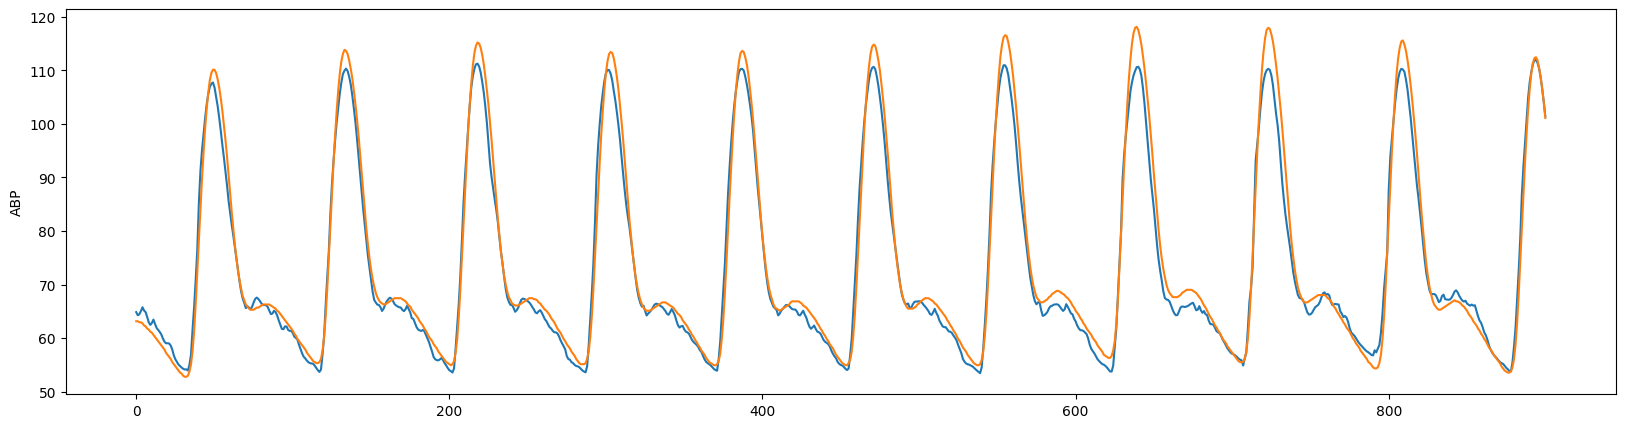

In [41]:
plt.figure(figsize=(20,5))
plt.plot(pred_abp[68:1000])
# plt.plot(pred_dia)
plt.plot(gt_abp[68:1000])
# plt.plot(gt_dia)
plt.ylabel('ABP')
plt.show()

In [42]:
pred_sys = zero_order_holding_first(pred_abp, delay=100, is_sys=True)
gt_sys = zero_order_holding_first(gt_abp, delay=100, is_sys=True)

pred_dia = zero_order_holding_first(pred_abp, delay=100, is_sys=False)
gt_dia = zero_order_holding_first(gt_abp, delay=100, is_sys=False)

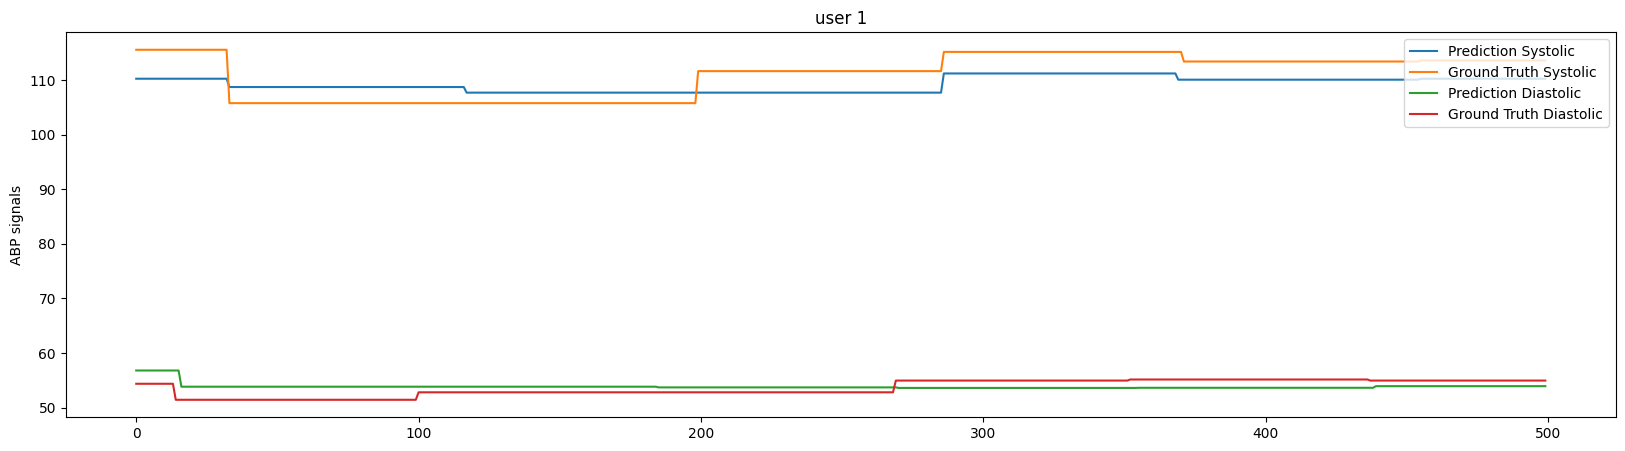

In [43]:
plt.figure(figsize=(20,5))
plt.plot(pred_sys[:500], label='Prediction Systolic')
plt.plot(gt_sys[:500], label='Ground Truth Systolic')
plt.plot(pred_dia[:500], label='Prediction Diastolic')
plt.plot(gt_dia[:500], label='Ground Truth Diastolic')
plt.ylabel('ABP signals')
plt.legend(loc='upper right')
plt.title('user ' + str(user_test+1))
plt.show()

In [48]:
import matplotlib.pyplot as plt
import numpy as np


from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import pandas as pd



In [49]:
pred_sys_ls = []
gt_sys_ls = []
pred_dia_ls = []
gt_dia_ls = []

rmse_sys_subjects = []
rmse_dia_subjects = []
mae_sys_subjects = []
mae_dia_subjects = []

for i in range(X_test.shape[0]):
    test_x, test_zeros, _ = to_timeseries(X_test[i], y_test[i], is_train=False, max_len=timewindow)
    ground_truth_x, _, ground_truth_y = to_timeseries(X_test[i], y_test[i], is_train=False, max_len=timewindow)
    y_test_predicted = model.predict([np.array(test_x), test_zeros],
                                     batch_size=batch_size)
    p_abp = []
    g_abp = []
    for j in range(y_test_predicted.shape[0]):
        p_abp.append(y_test_predicted[j][-1][0]*(abp_all_max-abp_all_min)+abp_all_min)
        g_abp.append(ground_truth_y[j][-1][0]*(abp_all_max-abp_all_min)+abp_all_min)


    p_sys = zero_order_holding_first(p_abp, delay=100, is_sys=True)
    g_sys = zero_order_holding_first(g_abp, delay=100, is_sys=True)
    p_dia = zero_order_holding_first(p_abp, delay=100, is_sys=False)
    g_dia = zero_order_holding_first(g_abp, delay=100, is_sys=False)


    p_sys = zero_order_second(p_sys)
    g_sys = zero_order_second(g_sys)
    p_dia = zero_order_second(p_dia)
    g_dia = zero_order_second(g_dia)

    pred_sys_ls.extend(p_sys)
    gt_sys_ls.extend(g_sys)
    pred_dia_ls.extend(p_dia)
    gt_dia_ls.extend(g_dia)

    rmse_sys_all = sqrt(mean_squared_error(gt_sys_ls, pred_sys_ls))
    rmse_dia_all = sqrt(mean_squared_error(gt_dia_ls, pred_dia_ls))
    mae_sys_all = mean_absolute_error(gt_sys_ls, pred_sys_ls)
    mae_dia_all = mean_absolute_error(gt_dia_ls, pred_dia_ls)

    rmse_sys_subjects.append(sqrt(mean_squared_error(g_sys, p_sys)))
    rmse_dia_subjects.append(sqrt(mean_squared_error(g_dia, p_dia)))
    mae_sys_subjects.append(mean_absolute_error(g_sys, p_sys))
    mae_dia_subjects.append(mean_absolute_error(g_dia, p_dia))

4/4 [==============================] - 0s 29ms/step


In [50]:
print('Overall RMSE Systolic: %.3f (mmHg)' % rmse_sys_all)
print('Overall RMSE Diastolic: %.3f (mmHg)' % rmse_dia_all)

Overall RMSE Systolic: 6.684 (mmHg)
Overall RMSE Diastolic: 3.444 (mmHg)


In [51]:
print('Overall MAE Systolic: %.3f (mmHg)' % mae_sys_all)
print('Overall MAE Diastolic: %.3f (mmHg)' % mae_dia_all)

Overall MAE Systolic: 5.137 (mmHg)
Overall MAE Diastolic: 2.532 (mmHg)


In [52]:
results = {'RMSE Systolic': rmse_sys_subjects,
           'RMSE Diastolic': rmse_dia_subjects,
           'MAE Systolic': mae_sys_subjects,
           'MAE Diastolic': mae_dia_subjects,
          }
df = pd.DataFrame(data=results)

In [53]:
df[:10].transpose()

,0,1,2,3,4,5,6,7,8,9
RMSE Systolic,5.102112,9.675147,9.654428,7.371880,10.243875,11.886169,6.897243,2.483506,6.821924,5.270111
RMSE Diastolic,1.338440,2.031037,2.954541,1.823617,3.164710,8.703108,7.592141,1.027781,1.605141,3.064644
MAE Systolic,4.744926,8.977740,9.066598,4.740256,9.318898,8.148938,5.228985,2.159286,6.617451,4.821588
MAE Diastolic,1.224611,1.899068,2.717741,1.559464,2.624244,8.208469,7.468402,0.875314,1.543367,2.947845
